# Trabalho #3 - Ajuste de função e métodos de otimização

Nesse trabalho você vai desenvolver uma rede neural deep-learning usando a plataforma TensorFlow-Keras, para realizar uma tarefa de ajuste de função e testar diferentes algorimos de otimização.

A função que será aprendida pela RNA nesse trabalho é o cálculo da orientação de um objeto no espaço tendo como dados as medidas de uma UMI (Unidade de Medida Inercial). Uma UMI possui 9 sensores: 3 acelerômetros, 3 magnetômetros e 3 giroscópios. Portanto, para cada eixo de um sistema de coordenadas cartesiano tem-se as medidas de um acelerômetro, um magnetômetro e um giroscópio. Assim, uma UMI mede as três componentes da aceleração linear, do vetor do campo magnético e da velocidade angular em cada eixo.

Nesse trabalho você também vai utilizar métodos de otimização avançados, que aceleram o processo de treinamento da RNA e, assim, talvez obter um desempenho melhor. Um algoritmo de otimização eficiente pode fazer a diferença entre esperar dias ou apenas alguns minutos para obter bons resultados.

## Coloque o seu nome aqui:

Aluno: Rodrigo Franciozi R. da Silva

RA: 20.83984-7

Para iniciar, execute a célula abaixo para importar algumas bilbiotecas básicas que usaremos nesse trabalho e iniciar o gerador de números aleatórios.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

np.random.seed(5)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1 - Visão geral do problema

A localização e navegação de veículos autônomos é um tópico importante para a área de robôs móveis. Em particular, a obtenção da orientação de um veículo autônomo aéreo é fundamental para o seu controle e representa um desafio importante e difícil a ser abordado. Muitos métodos calculam a orientação usando dados de uma UMI e algorítmos baseados em filtro de Kalman, filtro de partículas, filtros complementares etc. Porém, esses métodos são complicados e as grandes incertezas associadas às medidas das UMI de baixo custo fazem com que os resultados calculados para a orientação do veículo não sejam muito satisfatórios.

Nesse trabalho é fornecido um arquivo com os dados de treinamento que contém:

- medidas de 6 sensores de uma UMI (3 acelerômetros e 3 magnetômetros);
- resultados da orientação do veículo em relação aos 3 eixos do sistema de coordenadas fixo;
- cada linha do arquivo representa um conjunto de dados da UMI e a orientação real do objeto.

Observa-se que nesse trabalho não são usadas as medidas dos giroscópios, pois se fossem usados seria preciso usar uma rede com camadas recorrentes, que é capaz de processar séries temporais.

A partir desse conjunto de dados, a sua tarefa é desenvolver um sistema baseado em uma rede neural, para calcular a orientação do veículo no espaço 3D. Para isso, você vai desenvolver algumas redes neurais usando a ferramenta TensorFlow-Keras e comparar o desempenho delas. 

**Referências:** 

1) Os dados utilizados nesse trabalho foram obtidos por: Barsocchi, P., Crivello, A., La Rosa, D. e Palumbo, F. (2016, October). A multisource and multivariate dataset for indoor localization methods based on WLAN and geo-magnetic field fingerprinting. In Indoor Positioning and Indoor Navigation (IPIN), 2016 International Conference on (pp. 1-8). IEEE.

2) Esses dados estão disponíveis em: Geo-Magnetic field and WLAN dataset for indoor localisation from wristband and smartphone Data Set, UCI Machine Learning Repository, https://archive.ics.uci.edu/ml/datasets/Geo-Magnetic+field+and+WLAN+dataset+for+indoor+localisation+from+wristband+and+smartphone

## 2 - Dados de treinamento

Os dados que iremos utilizar nesse trabalho estão no arquivo `measurements.csv`. Cada linha desse arquivo representa uma medida da UMI.

As colunas desse arquivo representam as seguintes grandezas:

- coluna #1: instante de tempo da medidida;
- colunas #2 a #4: valores da aceleração linear nos eixos x, y e z do sistema de coordenadas fixo no veículo;
- colunas #5 a #7: valores da inclinação do campo magnético nos eixos x, y e z do sistema de coordenadas fixo no veículo;
- colunas #8 a #10: valores da orientação do veículo em relação aos eixos x, y e z do sistema de coordenadas fixo no ambiente (angulos de yaw, pitch e roll);

### 2.1 - Leitura dos dados

Para iniciar o trabalho é necessário ler o arquivo de dados e transformá-lo em um tensor numpy. Assim, execute o código da célula abaixo.

In [3]:
# Leitura do arquivo de dados
measurements = np.loadtxt('/content/drive/MyDrive/Education/IMT/Pós Graduação/IA com Deep Learning/Developing Neural Network Tools/Atividade 3/measurements.csv', 
                          delimiter=",",  skiprows=1, usecols=[1,2,3,4,5,6,7,8,9])
dados = np.array(measurements)

print('Dimensão do conjunto de dados:', dados.shape)
print(' Décimo exemplo dos dados:\n', dados[10])

Dimensão do conjunto de dados: (58374, 9)
 Décimo exemplo dos dados:
 [-2.8000e-02  3.5510e+00  8.9710e+00 -1.3790e+00  3.0300e+00 -4.5880e+01
  2.3020e+00 -2.1501e+01  2.6000e-02]


A dimensão do tensor com os dados é: 58374 linhas e 9 colunas. Portanto temos 58374 exemplos que podem ser usados como dados de treinamento, validação e teste. 

A décima linha do arquivo de dados foi impressa para se ter um ideia de como são os dados. Note que não usaremos nesse trabalho o instante de tempo da realização das medidas que aparece na primeira coluna, portanto, essa coluna foi descartada.

### 2.2 - Processamento dos dados

Para os dados poderem ser usados para o desenvolvimento da RNA devemos processá-los de várias formas.

### Exercício #1: Embaralhamento aleatório dos dados

Como os dados foram obtidos em uma sequencia temporal, cada linha está correlacionada com as linhas anteriores. Porém, como vamos usar esses dados somente para calcular a orientação do veículo, podemos considerar que cada linha representa uma medida independente. Assim, primeiramente vamos misturar as linhas com os dados para ter certeza que cada medida não esteja correlacionada com as medidas anteriores. 

Crie um código que embaralha os dados (linhas) e coloque as 6 primeiras colunas do tensor "dados" em um tensor de entradas "x" e as 3 últimas colunas do tensor "dados" em um tensor de saída "y". Para isso, use:

- a função numpy `random.shuffle(nome_tensor)` para realizar a tarefa de misturar as linhas de forma aleatória ([Dica])(https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.shuffle.html);
- o método de escolher elementos de um tensor visto na Aula 4 - Python em ML.

In [4]:
# PARA VOCÊ FAZER: Embaralhamento das linhas do arquivo de dados

np.random.seed(3)

# Insira seu programa aqui
np.random.shuffle(dados)
x = dados[:, :6]
y = dados[:, 6:]


print("Dimensão dos dados de entrada = ", x.shape)
print("Dimensão dos dados de saída = ", y.shape)
print("Décima linha do tensor de dados misturados:", dados[10])
print("Décima linha do tensor com os dados de entrada = ", x[10])
print("Décima linha do tensor com os dados de saída = ", y[10])


Dimensão dos dados de entrada =  (58374, 6)
Dimensão dos dados de saída =  (58374, 3)
Décima linha do tensor de dados misturados: [ -7.81   -5.113   3.471  45.557  -1.393  -0.743 287.665  54.653 -49.401]
Décima linha do tensor com os dados de entrada =  [-7.81  -5.113  3.471 45.557 -1.393 -0.743]
Décima linha do tensor com os dados de saída =  [287.665  54.653 -49.401]


**Saída esperada:**

    Dimensão dos dados de entrada =  (58374, 6)
    Dimensão dos dados de saída =  (58374, 3)
    Décima linha do tensor de dados misturados: [ -7.81   -5.113   3.471  45.557  -1.393  -0.743 287.665  54.653 -49.401]
    Décima linha do tensor com os dados de entrada =  [-7.81  -5.113  3.471 45.557 -1.393 -0.743]
    Décima linha do tensor com os dados de saída =  [287.665  54.653 -49.401]

**Visualização dos dados:**
    
Execute a célula abaixo para visualizar os dados de entrada e de saída. 

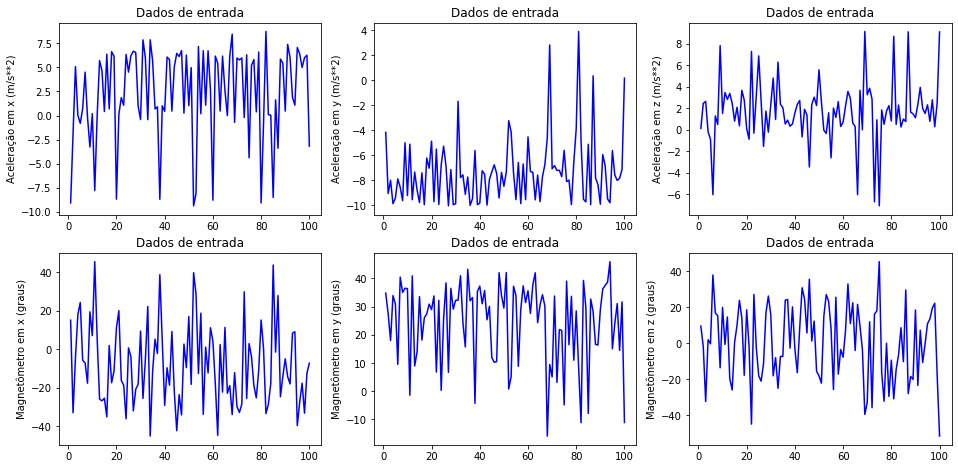

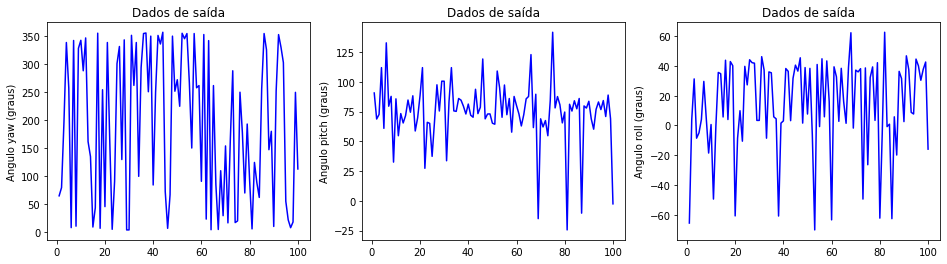

In [5]:
# Visualização dos dados
num = range(1, len(x) + 1)

plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 1)
plt.plot(num[0:100], x[0:100,0], 'b')
plt.title('Dados de entrada')
plt.ylabel('Aceleração em x (m/s**2)')

plt.subplot(3, 3, 2)
plt.plot(num[0:100], x[0:100,1], 'b')
plt.title('Dados de entrada')
plt.ylabel('Aceleração em y (m/s**2)')

plt.subplot(3, 3, 3)
plt.plot(num[0:100], x[0:100,2], 'b')
plt.title('Dados de entrada')
plt.ylabel('Aceleração em z (m/s**2)')

plt.subplot(3, 3, 4)
plt.plot(num[0:100], x[0:100,3], 'b')
plt.title('Dados de entrada')
plt.ylabel('Magnetômetro em x (graus)')

plt.subplot(3, 3, 5)
plt.plot(num[0:100], x[0:100,4], 'b')
plt.title('Dados de entrada')
plt.ylabel('Magnetômetro em y (graus)')

plt.subplot(3, 3, 6)
plt.plot(num[0:100], x[0:100,5], 'b')
plt.title('Dados de entrada')
plt.ylabel('Magnetômetro em z (graus)')
plt.show()

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(num[0:100], y[0:100,0], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo yaw (graus)')
plt.subplot(1, 3, 2)
plt.plot(num[0:100], y[0:100,1], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo pitch (graus)')
plt.subplot(1, 3, 3)
plt.plot(num[0:100], y[0:100,2], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo roll (graus)')
plt.show()

### Exercício #2: Divisão dos dados nos conjuntos de treinamento, validação e teste

Precisamos separar os dados nos conjuntos de treinamento, validação e teste. Como temos cerca de 60000 exemplos podemos separar os dados usando as regras que vimos em aula, assim, podemos fazer a seguinte divisão:

- Dados de treinamento: 42.000 exemplos;
- Dados de validação: 9.000 exemplos;
- Dados de teste: 9.000 exemplos.

In [6]:
# PARA VOCÊ FAZER: Divisão dos exemplos em dados de treinamento, validação e teste

# Dados de entrada:
# Insira seu programa aqui
x_train = x[:42000, :]
x_val = x[42000:51000, :]
x_test = x[51000:, :]

# Dados de saída
# Insira seu programa aqui
y_train = y[:42000, :]
y_val = y[42000:51000, :]
y_test = y[51000:, :]

m = len(x_train)
print("Número de exemplos de treinamento = ", m)
print("Dimensão do tensor de dados de entrada de treinamento =", x_train.shape)
print("Dimensão do tensor de dados de entrada de validação =", x_val.shape)
print("Dimensão do tensor de dados de entrada de teste =", x_test.shape)
print("Dimensão do tensor de dados de saída de treinamento =", y_train.shape)
print("Dimensão do tensor de dados de saída de validação =", y_val.shape)
print("Dimensão do tensor de dados de saída de teste =", y_test.shape)

Número de exemplos de treinamento =  42000
Dimensão do tensor de dados de entrada de treinamento = (42000, 6)
Dimensão do tensor de dados de entrada de validação = (9000, 6)
Dimensão do tensor de dados de entrada de teste = (7374, 6)
Dimensão do tensor de dados de saída de treinamento = (42000, 3)
Dimensão do tensor de dados de saída de validação = (9000, 3)
Dimensão do tensor de dados de saída de teste = (7374, 3)


**Saída esperada:**

    Número de exemplos de treinamento =  42000
    Dimensão do tensor de dados de entrada de treinamento = (42000, 6)
    Dimensão do tensor de dados de entrada de validação = (9000, 6)
    Dimensão do tensor de dados de entrada de teste = (7374, 6)
    Dimensão do tensor de dados de saída de treinamento = (42000, 3)
    Dimensão do tensor de dados de saída de validação = (9000, 3)
    Dimensão do tensor de dados de saída de teste = (7374, 3)

### Exercício #3: Normalização dos dados de entrada

Pode-se observar que os dados de entrada e de saída apresentam valores com grandes variações. As medidas dos acelerômetros variam entre -10 m/s^2 a +10 m/s^2, as medidas dos magnetômetros variam entre -40 graus a +60 graus e os ângulos de roll, pitch e yaw variam entre -60 graus a 350 graus. O ideal para esse tipo de dado é serem normalizados para que todas as medidas fiquem com média zero e desvio padrão igual a um. 

Crie um código na célula abaixo que calcula a média e o desvio padrão de cada coluna dos dados de entrada e de saída do conjunto de treinamento e use esses valores para normalizar os dados de entrada e de saída dos conjuntos de treinamento, validação e  teste. 

**Importante:** os dados de validação e de teste devem ser normalizados com a média e desvio padrão dos dados de treinamento  para evitar usar informações desses dois conjuntos de dados no treinamento da rede.

Para calcular a média e o desvio padrão das colunas de uma matriz A, use as funções da biblioteca numpy mean e std da seguinte forma:

- `media_das colunas = A.mean(axis=0)`
- `std_das_colunas = A.std(axis=0)`

Nos comando acima (`axis=0`) significa que é desejado calcular as médias e desvios padrão de cada coluna individualmente.


In [7]:
# PARA VOCÊ FAZER: Normalização dos dados

# Calculo das médias e desvios padrão dos dados de entrada do conjunto de treinamento
# Insira seu programa aqui
meanx = np.mean(x_train, axis = 0)
stdx =  np.std(x_train, axis = 0)

# Normalização das entradas dos dados de treinamento, validação e teste usando as médias meanx e os desvios padrão stdx.
# Insira seu programa aqui
x_train_norm = (x_train - meanx) / stdx
x_val_norm = (x_val - meanx) / stdx
x_test_norm = (x_test - meanx) / stdx

# Calculo das médias e desvios padrão dos dados de saida do conjunto de treinamento
# Insira seu programa aqui
meany = np.mean(y_train, axis = 0)
stdy = np.std(y_train, axis = 0)

# Normalização das saídas dos dados de treinamento, validação e teste usando as médias meany e os desvios padrão stdy.
# Insira seu programa aqui
y_train_norm = (y_train - meany) / stdy 
y_val_norm = (y_val - meany) / stdy
y_test_norm = (y_test - meany) / stdy

# impressão dos resultados para verificação
print("Médias entradas dados originais = ", meanx)
print("Desvios padrão entradas dados originais = ", stdx)
print("Médias entradas dados normalizados = ", x_train_norm.mean(axis=0))
print("Desvios padrão entradas dados normalizados = ", x_train_norm.std(axis=0))
print("Primeira linha entradas dados treinamento não normalizados = ", x_train[0])
print("Primeira linha entradas dados treinamento normalizados = ", x_train_norm[0])
print("Médias saidas dados originais = ", meany)
print("Desvios padrão saidas dados originais = ", stdy)
print("Médias saidas dados normalizados = ", y_train_norm.mean(axis=0))
print("Desvios padrão saidas dados normalizados = ", y_train_norm.std(axis=0))

Médias entradas dados originais =  [ 1.7284054  -7.0825429   1.92235279 -4.79793707 23.53039486  0.82130017]
Desvios padrão entradas dados originais =  [ 4.56402551  3.19370298  3.3329595  20.48106963 16.36872246 20.96476777]
Médias entradas dados normalizados =  [-5.59419971e-15 -7.24867521e-15 -2.20293360e-16 -1.09447107e-15
  5.34725042e-16  1.65793305e-16]
Desvios padrão entradas dados normalizados =  [1. 1. 1. 1. 1. 1.]
Primeira linha entradas dados treinamento não normalizados =  [-9.089 -4.167  0.127 15.138 34.79   9.439]
Primeira linha entradas dados treinamento normalizados =  [-2.37014569  0.91290359 -0.53866625  0.97338359  0.68787318  0.4110563 ]
Médias saidas dados originais =  [197.98929126  71.73479281  10.384772  ]
Desvios padrão saidas dados originais =  [126.36661067  35.44716153  30.21487999]
Médias saidas dados normalizados =  [-9.20717471e-15  1.13484485e-13  2.97196659e-15]
Desvios padrão saidas dados normalizados =  [1. 1. 1.]


**Saída esperada:**

    Médias entradas dados originais =  [ 1.7284054  -7.0825429   1.92235279 -4.79793707 23.53039486  0.82130017]
    Desvios padrão entradas dados originais =  [ 4.56402551  3.19370298  3.3329595  20.48106963 16.36872246 20.96476777]
    Médias entradas dados normalizados =  [-5.59419971e-15 -7.24867521e-15 -2.20293360e-16 -1.09447107e-15
      5.34725042e-16  1.65793305e-16]
    Desvios padrão entradas dados normalizados =  [1. 1. 1. 1. 1. 1.]
    Primeira linha entradas dados treinamento não normalizados =  [-9.089 -4.167  0.127 15.138 34.79   9.439]
    Primeira linha entradas dados treinamento normalizados =  [-2.37014569  0.91290359 -0.53866625  0.97338359  0.68787318  0.4110563 ]
    Médias saidas dados originais =  [197.98929126  71.73479281  10.384772  ]
    Desvios padrão saidas dados originais =  [126.36661067  35.44716153  30.21487999]
    Médias saidas dados normalizados =  [-9.20717471e-15  1.13484485e-13  2.97196659e-15]
    Desvios padrão saidas dados normalizados =  [1. 1. 1.]
      
**Observações:**      
- As médias das entradas dos dados normalizados são valores muito próximos de zero, como é de se esperar;
- A primeira linha dos dados de entrada treinamento não normalizados e a primeira linha dos dados normalizados servem como indicação de que os cálculos foram realizados de forma correta;
- As médias das saidas dos dados normalizados são valores muito próximos de zero, como é de se esperar.

Execute a célula abaixo para visualizar os gráficos dos dados de entrada e de saída normalizados do conjunto de exemplos de treinamento.

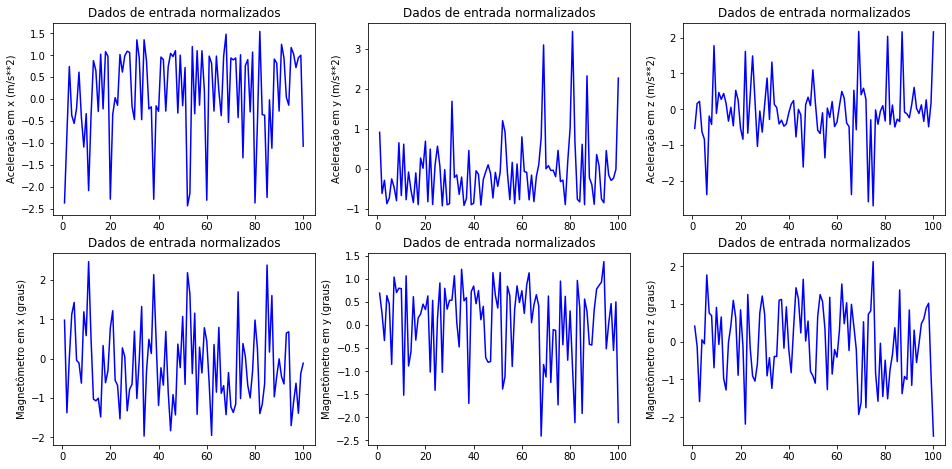

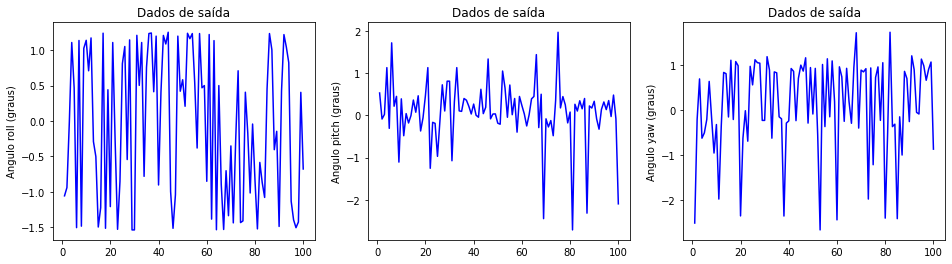

In [8]:
# Visualização dos dados de treinamento
num = range(1, len(x) + 1)

plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 1)
plt.plot(num[0:100], x_train_norm[0:100,0], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Aceleração em x (m/s**2)')

plt.subplot(3, 3, 2)
plt.plot(num[0:100], x_train_norm[0:100,1], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Aceleração em y (m/s**2)')

plt.subplot(3, 3, 3)
plt.plot(num[0:100], x_train_norm[0:100,2], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Aceleração em z (m/s**2)')

plt.subplot(3, 3, 4)
plt.plot(num[0:100], x_train_norm[0:100,3], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Magnetômetro em x (graus)')

plt.subplot(3, 3, 5)
plt.plot(num[0:100], x_train_norm[0:100,4], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Magnetômetro em y (graus)')

plt.subplot(3, 3, 6)
plt.plot(num[0:100], x_train_norm[0:100,5], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Magnetômetro em z (graus)')
plt.show()

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(num[0:100], y_train_norm[0:100,0], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo roll (graus)')
plt.subplot(1, 3, 2)
plt.plot(num[0:100], y_train_norm[0:100,1], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo pitch (graus)')
plt.subplot(1, 3, 3)
plt.plot(num[0:100], y_train_norm[0:100,2], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo yaw (graus)')
plt.show()

## 3 - Configuração da RNA

Nesse problema de ajuste de função deseja-se desenvolver uma RNA que aprenda a função que transforma os dados de entrada nos dados de saída. No problema de calcular a orientação de um veículo móvel usando dados de acelerômetros e magnetômetros, temos um conjunto de 6 equações não lineares cuja solução fornece os ângulos de roll, pitch e yaw, que representam a orientação do veículo em relação a um sistema de coordenadas fixo, portanto, temos 6 equações e 3 incógnitas.

Os fatores que dificultam uma solução satisfatória desse sistema de quações são os seguintes:

- As equações são complexas, envolvendo senos e cossenos, e a sua solução é interativa;
- Os dados dos sensores apresentam muito ruído e vieses. Para piorar os vieses variam no tempo;
- As medidas dos acelerômetros medem além das componentes da aceleração da gravidade, que é o que desejamos calcular, as acelerações do veículo e não é possível separar os dois tipos de aceleração.

### Exercício #4:

Para resolver esse problema você vai usar uma RNA com 4 camadas intermediárias e uma camada de saída com as seguintes características:

- Primeira camada: número de neurônios `n1`, função de ativação relu;
- Segunda camada: número de neurônios `n2`, função de ativação relu;
- Terceira camada: número de neurônios `n3`, função de ativação relu;
- Quarta camada: número de neurônios `n4`, função de ativação relu;
- Camada de saída: número de neurônio `n5 = 3` (temos 3 saídas), função de ativação linear.

Como iremos usar essa mesma RNA diversas vezes, na célula abaixo crie uma função que recebe a dimensão dos dados de entrada e os números de neurônios das 4 camadas intermediárias e configure a RNA de acordo com as características acima.

In [9]:
# PARA VOCÊ FAZER: Função para configuração da RNA

# Importa classes do Keras de modelos e camadas
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(data_shape, n1, n2, n3, n4, n5):
    """
    Essa função configura uma rede neural deep-learnig
    
    Argumentos:
    data_shape = tuple com dimensões dos dados de entrada da rede
    n1 = número de neurônios da primeira camada
    n2 = número de neurônios da segunda camada
    n3 = número de neurônios da terceira camada
    n4 = número de neurônios da quarta camada
       
    Retorna: modelo da rede neural
    """
    model = models.Sequential()
    
    # Adicione as camadas em seu modelo de RNA
    # Insira seu programa aqui
    model.add(layers.Dense(units = n1, activation = 'relu', input_dim = data_shape[0]))
    model.add(layers.Dense(units = n2, activation = 'relu'))
    model.add(layers.Dense(units = n3, activation = 'relu'))
    model.add(layers.Dense(units = n4, activation = 'relu'))
    model.add(layers.Dense(units = n5, activation = 'linear'))
    
    return model

Defina os números de neurônios das camadas intermediárias e de saída e crie a RNA usando a função `build_model()` criada na célula anterior. Utilize `n1 = 512`, `n2 = 512`, `n3 = 256`, `n4 = 128` e `n5 = 3`. Após criar a RNA utilize o método `summary()` para visualizar a sua rede.

In [10]:
# PARA VOCÊ FAZER: criação da RNA

# Dimensão dos dados de entrada
data_shape = (6,)

# Definição dos números de neurônios das camadas
# Insira seu programa aqui
n1 = 512
n2 = 512
n3 = 256
n4 = 128
n5 = 3

# Cria uma rede neural deep learning e apresenta sua configuração
# Insira seu programa aqui
rna = build_model(data_shape, n1, n2, n3, n4, n5)

rna.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               3584      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 430,851
Trainable params: 430,851
Non-trainable params: 0
_________________________________________________________________


**Saída esperada:**

    Model: "sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    dense (Dense)                (None, 512)               3584      
    _________________________________________________________________
    dense_1 (Dense)              (None, 512)               262656    
    _________________________________________________________________
    dense_2 (Dense)              (None, 256)               131328    
    _________________________________________________________________
    dense_3 (Dense)              (None, 128)               32896     
    _________________________________________________________________
    dense_4 (Dense)              (None, 3)                 387       
    =================================================================
    Total params: 430,851
    Trainable params: 430,851
    Non-trainable params: 0
    _________________________________________________________________

### Exercício #5:

Calcule o número de parâmetros da sua RNA. Escreva as contas realizadas e os seus resultados a seguir:

- Número de parâmetros da camada 1 = (512 * 6) + 512 = 3584
- Número de parâmetros da camada 2 = (512 * 512) + 512 = 262656
- Número de parâmetros da camada 3 = (256 * 512) + 256 = 131328
- Número de parâmetros da camada 4 = (128 * 256) + 128 = 32896
- Número de parâmetros da camada 5 = (3 * 128) + 3 = 387

## 4 - Compilação e treinamento da RNA 

Nesse trabalho você vai compilar e treinar a sua RNA usando vários métodos de otimização e depois vai comparar os resultados.

### 4.1 - Gradiente descendente

### Exercício #6: 

O primeiro método de otimização que você vai utilizar é o método padrão do gradiente descendente. Assim, na célula abaixo compile e treine a sua RNA usando os seguinte hiperparâmetros:

- Método do gradiente descendente de batelada;
- Função de custo: erro quadratico médio;
- Métrica: erro absoluto médio;
- Taxa de aprendizagem = 0,01;
- Número de épocas = 200;
- Batch_size = 1024;
- Verbose = 0. 

In [11]:
# PARA VOCÊ FAZER: Compilação e treinamento da RNA usando o método do gradiente descendente

# importa do keras a classe dos otimizadores
from tensorflow.keras import optimizers

EPOCHS = 200
BATCH_SIZE = 1024

# Compilação da rede
# Insira seu programa aqui
rna.compile(optimizer = optimizers.SGD(learning_rate = 0.01), loss = tf.keras.losses.mean_squared_error, metrics='mae')                  
                     
# Treinamento da RNA
# Insira seu programa aqui
history = rna.fit(x_train_norm, y_train_norm, epochs = EPOCHS, validation_data = (x_val_norm, y_val_norm), batch_size = BATCH_SIZE, verbose = 0)


### Análise dos resultados

Execute as duas células a seguir para fazer os gráficos da função de custo e da métrica (erro absoluto médio) para os dados de treinamento e validação.

In [12]:
# Salva treinamento na variável history para visualização
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

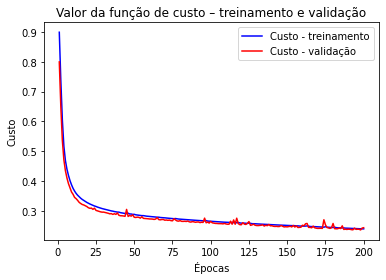

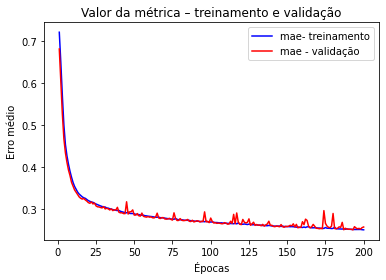

In [13]:
# Salva custos, métricas e epocas em vetores 
custo = history_dict['loss']
mae = history_dict['mae']
val_custo = history_dict['val_loss']
val_mae = history_dict['val_mae']

# Cria vetor de épocas
epocas = range(1, len(custo) + 1)

# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento')
plt.plot(epocas, val_custo, 'r', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas, mae, 'b', label='mae- treinamento')
plt.plot(epocas, val_mae, 'r', label='mae - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Erro médio')
plt.legend()
plt.show()

Dos gráficos dos valores da função de custo e da métrica você pode concluir o seguinte:

- O treinamento da RNA está sendo efetivo, pois o valor da função de custo e do erro absoluto médio diminuem o tempo todo durante o treinamento, tanto para os dados de treinamento com de validação.
- Os resultados obtidos para os dados de treinamento e de validação são praticamente iguais.
- Os parâmetros da RNA ainda não convergiram para os seus valores ótimos, ainda seriam necessárias algumas épocas para finalizar o treinamento.

### Exercício #7: 

O desempenho real da RNA deve ser verificado com os dados de teste. Para fazer isso, calcule os valores da função de custo e da métrica para os dados de teste.

In [14]:
# PARA VOCÊ FAZER: calculo do custo e métrica para os dados de treinamento, validação e teste

# Usando o método evaluate calcule o custo e a exatidão e depois apresente os resultados
# Insira seu programa aqui
print(rna.evaluate(x_train_norm, y_train_norm))
print(rna.evaluate(x_val_norm, y_val_norm))
print(rna.evaluate(x_test_norm, y_test_norm))


1313/1313 [==============================] - 3s 2ms/step - loss: 0.2469 - mae: 0.2593
[0.2469375729560852, 0.25926023721694946]
282/282 [==============================] - 1s 2ms/step - loss: 0.2430 - mae: 0.2583
[0.24304215610027313, 0.25830721855163574]
231/231 [==============================] - 1s 3ms/step - loss: 0.2489 - mae: 0.2607
[0.24894437193870544, 0.2606836259365082]


**Saída esperada:**

    1313/1313 [==============================] - 2s 1ms/step - loss: 0.2641 - mae: 0.2771
    282/282 [==============================] - 0s 1ms/step - loss: 0.2603 - mae: 0.2765
    231/231 [==============================] - 0s 1ms/step - loss: 0.2657 - mae: 0.2786

Você deve observar que o desempenho da RNA nos dados de teste é praticamente o mesmo que o obtido para os dados de treinamento e de validação.


### Para você fazer após entregar o trabalho:

Altere o tamanho do lote para algo entre 32 e 1024 e execute o treinamento novamente usando 500 épocas. Mas para isso comece de novo do item 3, senão a rede vai continuar o treinamento e você irá concluir erroneamente que diminuindo o tamanho da batelada o treinamento é melhor.

## 4.2 - Gradiente descendente com momento

### Exercício #8: 

Agora você vai treinar a sua RNA usando o método de otimização do gradiente descentende com momento. Assim, na célula abaixo, configure uma nova RNA (use um nome diferente da RNA anterior), com o mesmo números de neurônios nas 5 camadas, usando a função `build_model()`. Depois compile e treine a sua nova RNA usando os seguinte hiperparâmetros:

- Método do gradiente descendente com momento;
- Função de custo: erro quadráico médio;
- Métrica: erro absoluto médio;
- Constante beta1 = 0,9;
- Taxa de aprendizagem = 0,01;
- Decaimento da taxa de apredizagem = 1e-02;
- Nesterov = True
- Número de épocas = 200;
- Batch_size = 1024;
- Verbose = 0.

In [15]:
# PARA VOCÊ FAZER: Configuração, compilação e treinamento da RNA usando o método do gradiente descendente com momento

EPOCHS = 200
BATCH_SIZE = 1024

# Configuração da RNA
# Insira seu programa aqui
rnaM = build_model(data_shape, n1, n2, n3, n4, n5)


# Configuração do otimizador e compilação da rede 
# Insira seu programa aqui
rnaM.compile(optimizer = optimizers.SGD(learning_rate = 0.01, decay = 1e-02, momentum = 0.9, nesterov = True), loss = tf.keras.losses.mean_squared_error, metrics = 'mae')     

# Treinamento da RNA
# Insira seu programa aqui
historyM = rnaM.fit(x_train_norm, y_train_norm, epochs = EPOCHS, validation_data = (x_val_norm, y_val_norm), batch_size = BATCH_SIZE, verbose = 0)



### Análise dos resultados

Execute as três células a seguir para fazer os gráficos da função de custo e da métrica (erro absoluto médio) para os dados de treinamento e validação, e calcular o custo e o erro absoluto médio para os dados de teste.

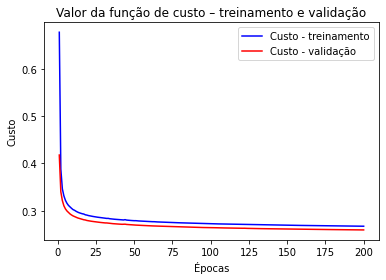

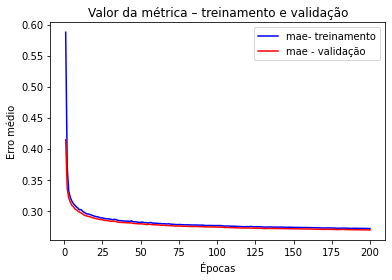

In [16]:
# Salva treinamento na variável history para visualização
history_dictM = historyM.history
history_dictM.keys()

# Salva custos, métricas e epocas em vetores 
custoM = history_dictM['loss']
maeM = history_dictM['mae']
val_custoM = history_dictM['val_loss']
val_maeM = history_dictM['val_mae']

# Cria vetor de épocas
epocasM = range(1, len(custoM) + 1)

# Gráfico dos valores de custo
plt.plot(epocasM, custoM, 'b', label='Custo - treinamento')
plt.plot(epocasM, val_custoM, 'r', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocasM, maeM, 'b', label='mae- treinamento')
plt.plot(epocasM, val_maeM, 'r', label='mae - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Erro médio')
plt.legend()
plt.show()


In [17]:
# Calculo do custo e a exatidão para os dados de treinamemto, validação e teste
custo_e_metricas_train = rnaM.evaluate(x_train_norm, y_train_norm)
custo_e_metricas_val = rnaM.evaluate(x_val_norm, y_val_norm)
custo_e_metricas_test = rnaM.evaluate(x_test_norm, y_test_norm)

231/231 [==============================] - 1s 2ms/step - loss: 0.2686 - mae: 0.2715


**Saída esperada:**

    1313/1313 [==============================] - 2s 1ms/step - loss: 0.2665 - mae: 0.2708
    282/282 [==============================] - 0s 1ms/step - loss: 0.2592 - mae: 0.2691
    231/231 [==============================] - 0s 1ms/step - loss: 0.2675 - mae: 0.2712

Dos gráficos dos valores da função de custo e da métrica você pode concluir o seguinte:

- O resultado do treinamento da RNA usando o método do gradiente descendente com momento é ligeiramente superior ao sem momento.
- Os parâmetros da RNA convergiram mais rápido do que no método sem momento, mas ainda não convergiram completamente para os seus valores ótimos. Ainda seriam necessárias algumas épocas para finalizar o treinamento.
- O erro absoluto médio é da ordem de 27% para os dados de treinamento, validação e teste. Isso pode ser considerado um bom resultado, dado a complexidade do problema e o número pequeno de épocas de treinamento. 

### 4.3 - RMSprop

### Exercício #9: 

Agora você vai treinar a sua RNA usando o método de otimização RMSprop. Assim, na célula abaixo, configure uma nova RNA (use um nome diferente da RNA anterior), com o mesmo números de neurônios nas 5 camadas, usando a função `build_model()`. Depois compile e treine a sua nova RNA usando os seguinte hiperparâmetros:

- Método de otimização RMSprop;
- Função de custo: erro quadrático médio;
- Métrica: erro absoluto médio;
- Taxa de aprendizagem = 0,01;
- Número de épocas = 200;
- Batch_size = 1024;
- Verbose = 0.

In [18]:
# PARA VOCÊ FAZER: Configuração, compilação e treinamento da RNA usando o método RMSprop

EPOCHS = 200
BATCH_SIZE = 1024

# Configuração da RNA
# Insira seu programa aqui
rnaR = build_model(data_shape, n1, n2, n3, n4, n5)


# Configuração do otimizador e compilação da rede 
# Insira seu programa aqui
rnaR.compile(optimizer = optimizers.RMSprop(learning_rate = 0.01), loss = tf.keras.losses.mean_squared_error, metrics = 'mae')     
 
# Treinamento da RNA
# Insira seu programa aqui
historyR = rnaR.fit(x_train_norm, y_train_norm, epochs = EPOCHS, validation_data = (x_val_norm, y_val_norm), batch_size = BATCH_SIZE, verbose = 0)

### Análise dos resultados

Execute as três células a seguir para fazer os gráficos da função de custo e da métrica (erro absoluto médio) para os dados de treinamento e validação, e calcular o custo e o erro absoluto médio para os dados de teste.

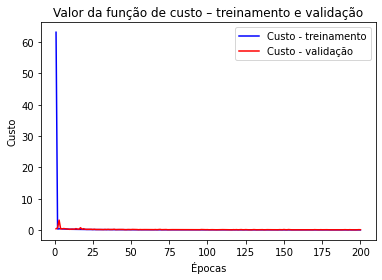

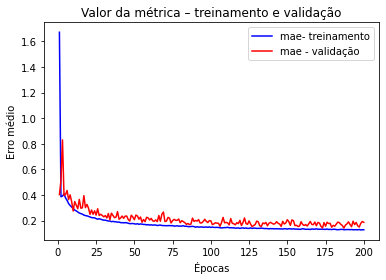

In [19]:
# Salva treinamento na variável history para visualização
history_dictR = historyR.history
history_dictR.keys()

# Salva custos, métricas e epocas em vetores 
custoR = history_dictR['loss']
maeR = history_dictR['mae']
val_custoR = history_dictR['val_loss']
val_maeR = history_dictR['val_mae']

# Cria vetor de épocas
epocasR = range(1, len(custoR) + 1)

# Gráfico dos valores de custo
plt.plot(epocasR, custoR, 'b', label='Custo - treinamento')
plt.plot(epocasR, val_custoR, 'r', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocasR, maeR, 'b', label='mae- treinamento')
plt.plot(epocasR, val_maeR, 'r', label='mae - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Erro médio')
plt.legend()
plt.show()


In [20]:
# Calculo do custo e a exatidão para os dados de treinamemto, validação e teste
custo_e_metricas_train = rnaR.evaluate(x_train_norm, y_train_norm)
custo_e_metricas_val = rnaR.evaluate(x_val_norm, y_val_norm)
custo_e_metricas_test = rnaR.evaluate(x_test_norm, y_test_norm)

231/231 [==============================] - 1s 2ms/step - loss: 0.1079 - mae: 0.1847


**Saída esperada:**

    1313/1313 [==============================] - 2s 1ms/step - loss: 0.0651 - mae: 0.1421
    282/282 [==============================] - 0s 1ms/step - loss: 0.0865 - mae: 0.1560
    231/231 [==============================] - 0s 1ms/step - loss: 0.0892 - mae: 0.1584

Dos gráficos dos valores da função de custo e da métrica você pode concluir o seguinte:

- O treinamento da RNA usando o método RMSprop é mais rápido do que os dois métodos anteriores (SGD e  GD com Momento), como pode ser observado pelos valores da função de custo e da métrica que convergem rapidamente para um valor constante.
- Os resultados obtidos para os dados de treinamento, validação e teste são são melhorees do que para os dois casos anterires.
- Os parâmetros da RNA quase convergiram, mas a RNA aida não apresenta um desempenho muito satisfatório.
- O erro absoluto médio é da ordem de 14% para os dados de treinamento e de 16% para os dados de validação e de teste. Isso pode ser considerado um resultado médio, dado a complexidade do problema.

### 4.4 - ADAM

### Exercício #10: 

Agora você vai treinar a sua RNA usando o método de otimização ADAM. Assim, na célula abaixo, configure uma nova RNA (use um nome diferente da RNA anterior), com o mesmo números de neurônios nas 5 camadas, usando a função `build_model()`. Depois compile e treine a sua nova RNA usando os seguinte hiperparâmetros:

- Método de otimização: Adam;
- Função de custo: erro quadrático médio;
- Métrica: erro absoluto médio;
- Taxa de aprendizagem = 0,001;
- Decaimento da taxa de apredizagem = 0;
- Número de épocas = 200;
- Batch_size = 1024;
- Verbose = 0.

In [21]:
# PARA VOCÊ FAZER: Configuração, compilação e treinamento da RNA usando o método RMSprop

EPOCHS = 200
BATCH_SIZE = 1024

# Configuração da RNA
# Insira seu programa aqui
rnaA = build_model(data_shape, n1, n2, n3, n4, n5)


# Configuração do otimizador e compilação da rede 
# Insira seu programa aqui
rnaA.compile(optimizer = optimizers.Adam(learning_rate = 0.001, decay = 0), loss = tf.keras.losses.mean_squared_error, metrics = 'mae')     

# Treinamento da RNA
# Insira seu programa aqui
historyA = rnaA.fit(x_train_norm, y_train_norm, epochs = EPOCHS, validation_data = (x_val_norm, y_val_norm), batch_size = BATCH_SIZE, verbose = 0)

### Análise dos resultados

Execute as três células a seguir para fazer os gráficos da função de custo e da métrica (erro absoluto médio) para os dados de treinamento e validação, e calcular o custo e o erro absoluto médio para os dados de teste.

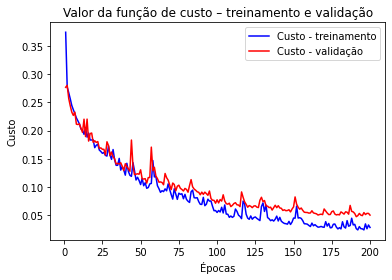

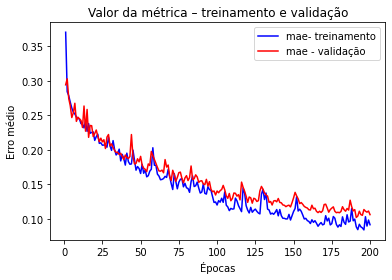

In [22]:
history_dictA = historyA.history
history_dictA.keys()

# Salva custos, métricas e epocas em vetores 
custoA = history_dictA['loss']
maeA = history_dictA['mae']
val_custoA = history_dictA['val_loss']
val_maeA = history_dictA['val_mae']

# Cria vetor de épocas
epocasA = range(1, len(custoA) + 1)

# Gráfico dos valores de custo
plt.plot(epocasA, custoA, 'b', label='Custo - treinamento')
plt.plot(epocasA, val_custoA, 'r', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocasA, maeA, 'b', label='mae- treinamento')
plt.plot(epocasA, val_maeA, 'r', label='mae - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Erro médio')
plt.legend()
plt.show()

In [23]:
# Calculo do custo e a exatidão para os dados de treinamemto, validação e teste
custo_e_metricas_train = rnaA.evaluate(x_train_norm, y_train_norm)
custo_e_metricas_val = rnaA.evaluate(x_val_norm, y_val_norm)
custo_e_metricas_test = rnaA.evaluate(x_test_norm, y_test_norm)

231/231 [==============================] - 1s 2ms/step - loss: 0.0549 - mae: 0.1073


**Saída esperada:**

    1313/1313 [==============================] - 2s 1ms/step - loss: 0.0270 - mae: 0.0908
    282/282 [==============================] - 0s 1ms/step - loss: 0.0523 - mae: 0.1112
    231/231 [==============================] - 0s 1ms/step - loss: 0.0581 - mae: 0.1129

Dos gráficos dos valores da função de custo e da métrica você pode concluir o seguinte:

- Pelos gráficos da função de custo e da métrica, o treinamento da RNA usando o método ADAM obteve bem melhores do que os obtidos com os três métodos anteriores (GD, GD com Momento e RMSprop).
- Os resultados obtidos para os dados de treinamento são um pouco melhores do que para os dados de validação e de teste.
- Os parâmetros da RNA ainda não convergiram para os seus valores ótimos, ainda seriam necessárias algumas épocas para finalizar o treinamento.
- O erro absoluto médio é da ordem de 9% para os dados de treinamento de 11% para os dados de validação e teste. Isso pode ser considerado um resultado médio, dado a complexidade do problema e o número pequeno de épocas de treinamento. 

### 4.5 - Resumo dos resultados

A tabela apresenta os resultados obtidos pelos diversos métodos de otimização para os dados de teste.
<table> 
    <tr>
        <td>
        Método de otimização
        </td>
        <td>
        Erro absoluto médio
        </td>
        <td>
        Função de custo
        </td>

   </tr>
        <td>
        Gradiente Descendente
        </td>
        <td>
        0,28
        </td>
        <td>
        0,266
        </td>
    <tr>
        <td>
        GD com momento
        </td>
        <td>
        0.27
        </td>
        <td>
        0,268
    </td>
    </tr>
    
   <tr>
        <td>
        RMSprop
        </td>
        <td>
        0.16
        </td>
        <td>
        0,089
        </td>
    </tr>    
    
    
   <tr>
        <td>
        Adam
        </td>
        <td>
        0,11
        </td>
        <td>
        0,058
        </td>
    </tr>
</table> 

Por esses resultados pode-se conluir que o desemepnho da RNA não é satisfatório. Mas isso é certamente causado pelo fato de que não tentamos otimizar os hiperparâmetros da rede. Se tivéssemos feito alguns ajustes, tais como, aumentar número de camadas, aumentar número de neurônios, aumentar número de épocas de treinamento etc, certamente os resultados seriam muito melhores.

### 5 - Cálculo das saídas previstas

### Exercício #11: 

Calcule as saídas previstas pela RNA e o erro absoluto médio percentual para os exemplos de teste. Para isso execute a sua RNA treinada pelo método Adam e depois faça os gráficos dos resultados obtidos para os 100 primeiros exemplos de teste. Implemente o seu código na célula abaixo.

Erro absoluto médio percentual:  10.729152739520393


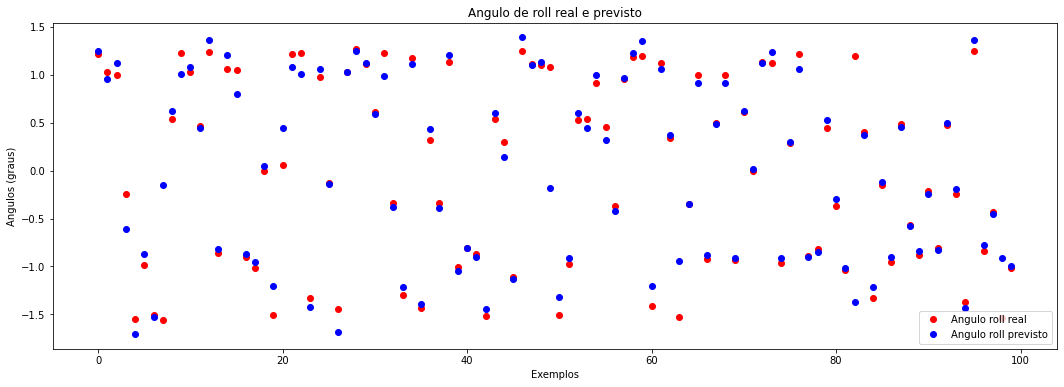

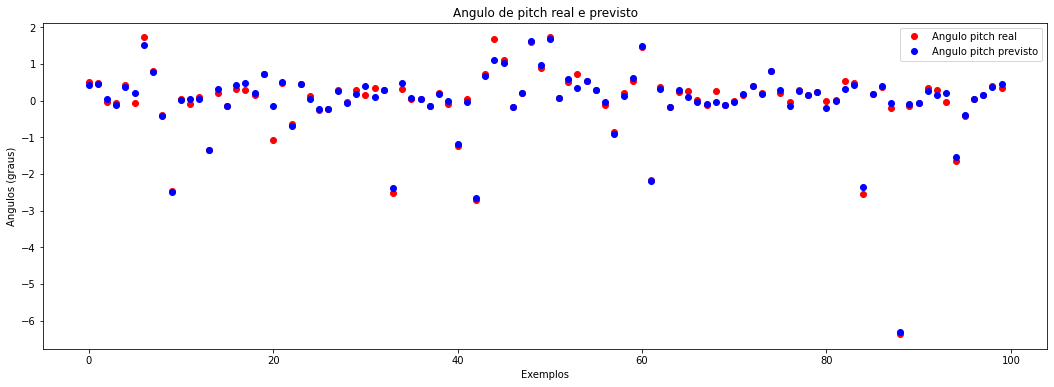

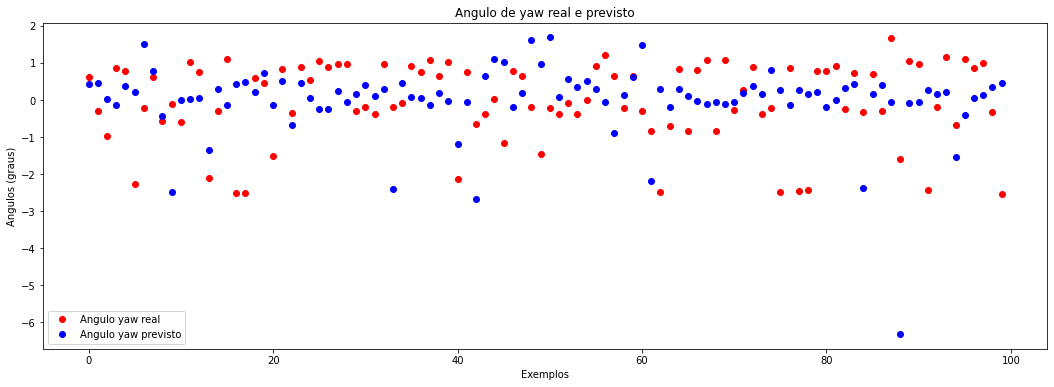

In [24]:
# PARA VOCÊ FAZER: calculo das saídas previstas para os dados de teste e erro absoluto percentual

# Usando método predict calcule as classes previstas
# Insira seu programa aqui
y_pred = rnaA.predict(x_test_norm)
 
# Calcule o erro absoluto médio percentual 
# Insira seu programa aqui
from sklearn.metrics import mean_absolute_error
mean_absolute_error = mean_absolute_error(y_test_norm, y_pred)

print('Erro absoluto médio percentual: ', mean_absolute_error * 100) 

# Gráfico dos ângulos de yaw reais e previstos para os primeiros 100 exemplos
plt.figure(figsize=(18, 6))
plt.plot(y_test_norm[:100,0], 'ro', label='Angulo roll real')
plt.plot(y_pred[:100,0], 'bo', label='Angulo roll previsto')
plt.title('Angulo de roll real e previsto')
plt.xlabel('Exemplos')
plt.ylabel('Angulos (graus)')
plt.legend()
plt.show()

# Gráfico dos ângulos de pitch reais e previstos para os primeiros 100 exemplos
### COMECE AQUI ### (≈ 7 linhas)
plt.figure(figsize=(18, 6))
plt.plot(y_test_norm[:100,1], 'ro', label='Angulo pitch real')
plt.plot(y_pred[:100,1], 'bo', label='Angulo pitch previsto')
plt.title('Angulo de pitch real e previsto')
plt.xlabel('Exemplos')
plt.ylabel('Angulos (graus)')
plt.legend()
plt.show()
### TERMINE AQUI ###

# Gráfico dos ângulos de roll reais e previstos para os primeiros 100 exemplos
### COMECE AQUI ### (≈ 7 linhas)
plt.figure(figsize=(18, 6))
plt.plot(y_test_norm[:100,2], 'ro', label='Angulo yaw real')
plt.plot(y_pred[:100,1], 'bo', label='Angulo yaw previsto')
plt.title('Angulo de yaw real e previsto')
plt.xlabel('Exemplos')
plt.ylabel('Angulos (graus)')
plt.legend()
plt.show()
### TERMINE AQUI ###

### Análise dos resultados:

Pelos gráficos acima pode-se facilmente verificar que os resultados obttidos não são bons e que falta ainda muito trabalho para se obter uma solução com desempenho satisfatório.

## Para você fazer após entregar o trabalho:

Para melhorar os resultados da sua RNA você pode tentar diversas coisas, tais como:

- Aumentar o número de camadas e neurônios da RNA;
- Utilizar um número maior de épocas de treinamento;
- Alterar o tamanho dos lotes;
- Usar decaimento da taxa de aprendizado;
- Testar outros valores para os hiperparâmetros dos otimizadores.

Tente fazer algumas dessas coisas e veja se consegue obter resultados melhores. 